In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print("TF Version: " + tf.__version__)

TF Version: 2.16.1


### Data Preperation
Here we are selecting a small percentage of the original dataset, this is to increase the speed at which the models train.
This is done using the line dataset = dataset.sample

We then drop the region column from the dataset as we will not be using it in the training of the models
e:

In [2]:
#Read data from file

raw_dataset = pd.read_csv("insurance_dataset.csv", sep=',',decimal='.')


In [3]:
dataset = raw_dataset.copy()
dataset = dataset.sample(frac=0.005, random_state=42)#0.5% of 1 million = 5,000, likely need to increase
dataset.drop(columns=['region'], inplace=True) #Drop the region as we will not be using it
print("Number of rows in the dataset after sampling:", dataset.shape[0])
dataset.reset_index(drop=True, inplace=True)
dataset.tail(9)

Number of rows in the dataset after sampling: 5000


,age,gender,bmi,children,smoker,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
4991,42,male,31.18,3,yes,High blood pressure,Diabetes,Never,Blue collar,Basic,16272.151930
4992,46,male,28.89,4,yes,Diabetes,Heart disease,Frequently,Unemployed,Standard,22953.606080
4993,57,male,35.78,5,yes,Diabetes,Diabetes,Frequently,White collar,Standard,21828.655940
4994,21,male,22.20,2,no,NaN,Diabetes,Rarely,Student,Basic,7782.781926
4995,46,female,43.61,3,yes,High blood pressure,Heart disease,Rarely,Student,Standard,19765.111890
4996,28,female,34.46,3,no,NaN,Diabetes,Frequently,Unemployed,Basic,9406.823145
4997,65,male,33.47,0,no,Heart disease,High blood pressure,Occasionally,Blue collar,Basic,15161.968770
4998,56,male,39.00,3,no,NaN,Heart disease,Frequently,Student,Standard,16416.199640
4999,65,male,18.34,1,yes,NaN,High blood pressure,Frequently,White collar,Premium,20258.384190


In [4]:
from sklearn.preprocessing import LabelEncoder
# Create label encoder
label_encoder = LabelEncoder()
# Define ordinal mappings for ordinal variables
ordinal_mappings = {
    "gender": {"male": 0, "female": 1},
    "smoker": {"no": 0, "yes": 1},
    "medical_history": {np.NAN: 0, "Heart disease": 1, "High blood pressure": 2, "Diabetes": 3},
    "family_medical_history": {np.NAN: 0, "Heart disease": 1, "High blood pressure": 2, "Diabetes": 3},
    "exercise_frequency": {"Never": 0, "Rarely": 1, "Occasionally": 2, "Frequently": 3},
    "occupation": {"Unemployed": 0, "Student": 1, "Blue collar": 2, "White collar": 3},
    "coverage_level": {"Basic": 0, "Standard": 1, "Premium": 2}
}
def encode_values(new_dataset):
    # Apply ordinal encoding to ordinal variables
    new_dataset.replace(ordinal_mappings, inplace=True)
    return new_dataset

# Apply the function to your dataset
dataset = encode_values(dataset)


dataset.tail(9)

,age,gender,bmi,children,smoker,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
4991,42,0,31.18,3,1,2,3,0,2,0,16272.151930
4992,46,0,28.89,4,1,3,1,3,0,1,22953.606080
4993,57,0,35.78,5,1,3,3,3,3,1,21828.655940
4994,21,0,22.20,2,0,0,3,1,1,0,7782.781926
4995,46,1,43.61,3,1,2,1,1,1,1,19765.111890
4996,28,1,34.46,3,0,0,3,3,0,0,9406.823145
4997,65,0,33.47,0,0,1,2,2,2,0,15161.968770
4998,56,0,39.00,3,0,0,1,3,1,1,16416.199640
4999,65,0,18.34,1,1,0,2,3,3,2,20258.384190


In [5]:
'''from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Assuming 'coverage_level' is a column in your dataset
# Convert 'coverage_level' to categorical data type (optional but recommended)
dataset['coverage_level'] = dataset['coverage_level'].astype('category')

# Drop the 'coverage_level' column temporarily
coverage_level = dataset.pop('coverage_level')

# Initialize SimpleImputer to handle missing values
imputer = SimpleImputer(strategy='most_frequent')
dataset_imputed = pd.DataFrame(imputer.fit_transform(dataset), columns=dataset.columns)

# Initialize OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the coverage_level column
coverage_encoded = encoder.fit_transform(coverage_level.values.reshape(-1, 1))

# Convert the encoded sparse matrix to a dense array and create a DataFrame
coverage_encoded_df = pd.DataFrame(coverage_encoded.toarray(), columns=encoder.get_feature_names_out(['coverage_level']))

# Concatenate the imputed dataset with the one-hot encoded coverage level
dataset_encoded = pd.concat([dataset_imputed, coverage_encoded_df], axis=1)

dataset = dataset_encoded

# Print the head of the encoded dataset
dataset.tail()'''

"from sklearn.preprocessing import OneHotEncoder\nfrom sklearn.impute import SimpleImputer\n\n# Assuming 'coverage_level' is a column in your dataset\n# Convert 'coverage_level' to categorical data type (optional but recommended)\ndataset['coverage_level'] = dataset['coverage_level'].astype('category')\n\n# Drop the 'coverage_level' column temporarily\ncoverage_level = dataset.pop('coverage_level')\n\n# Initialize SimpleImputer to handle missing values\nimputer = SimpleImputer(strategy='most_frequent')\ndataset_imputed = pd.DataFrame(imputer.fit_transform(dataset), columns=dataset.columns)\n\n# Initialize OneHotEncoder\nencoder = OneHotEncoder()\n\n# Fit and transform the coverage_level column\ncoverage_encoded = encoder.fit_transform(coverage_level.values.reshape(-1, 1))\n\n# Convert the encoded sparse matrix to a dense array and create a DataFrame\ncoverage_encoded_df = pd.DataFrame(coverage_encoded.toarray(), columns=encoder.get_feature_names_out(['coverage_level']))\n\n# Concatenat

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

# Split the encoded dataset into features (X) and target variables (y_charges, y_coverage)
X = dataset.drop(columns=['charges', 'coverage_level'])  # Features
y_charges = dataset['charges']  # Target variable for charges
y_coverage = dataset['coverage_level']  # Target variable for coverage

# Split the data into training and testing sets for charges and coverage separately
X_train, X_test, y_charges_train, y_charges_test = train_test_split(
    X, y_charges, test_size=0.2, random_state=42
)
X_train, X_test, y_coverage_train, y_coverage_test = train_test_split(
    X, y_coverage, test_size=0.2, random_state=42
)

# Concatenate the target variables
y_train = pd.concat([y_charges_train, y_coverage_train], axis=1)
y_test = pd.concat([y_charges_test, y_coverage_test], axis=1)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (4000, 9)
Shape of y_train: (4000, 2)
Shape of X_test: (1000, 9)
Shape of y_test: (1000, 2)


In [7]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit scaler on training data and transform both training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Multi Output Random Forest Regressor

This random forest regressor is wrapped with a multi output regressor to make it so that we can predict both 

In [29]:
# Define parameter grid for hyperparameter tuning
##param_grid = {
#    'n_estimators': [100, 200, 300],  # Number of trees in the forest
#    'max_depth': [None, 10, 20],  # Maximum depth of the tree
#    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
#    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
#    'max_features': ['auto', 'sqrt']  # Number of features to consider when looking for the best split
#}

param_grid_rf = {
    'estimator__max_depth': [10, 20, 30],
    'estimator__n_estimators': [100, 200, 300]
}


# Instantiate Random Forest regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Wrap the Random Forest regressor with MultiOutputRegressor
multioutput_regressor = MultiOutputRegressor(rf_regressor)

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=multioutput_regressor, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_rf_model = grid_search.best_estimator_

# Make predictions on the testing data
y_pred = best_rf_model.predict(X_test)

# Split the predictions into separate arrays for charges and coverage
y_charges_pred = y_pred[:, 0]  # Assuming charges is the first output variable
y_coverage_pred = y_pred[:, 1]  # Assuming coverage is the second output variable

# Evaluate the model
mse_charges = mean_squared_error(y_charges_test, y_charges_pred)
mse_coverage = mean_squared_error(y_coverage_test, y_coverage_pred)
print("Mean Squared Error (Charges):", mse_charges)
print("Mean Squared Error (Coverage Level):", mse_coverage)

Mean Squared Error (Charges): 4979655.2293741135
Mean Squared Error (Coverage Level): 0.6485561332617651


### Multi output SVM Regressor

Here we use the SVR Model from sklearn to create a SVM regression model that will predict the charges and the coverage type


In [25]:
from sklearn.svm import SVR

# 1. Instantiate the SVM Regressor
svm_regressor = SVR()

# 2. Hyperparameter Tuning
param_grid = {
    'estimator__kernel': ['linear', 'rbf'],
    'estimator__C': [0.1, 1, 10],
    'estimator__epsilon': [0.1, 0.2, 0.5]
}
##Wrap the svm regressor in a multi output regressor
grid_search = GridSearchCV(estimator=MultiOutputRegressor(svm_regressor), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# 3. Train the Model
grid_search.fit(X_train, y_train)

# 4. Evaluate the Model
best_svm_model = grid_search.best_estimator_
y_pred = best_svm_model.predict(X_test)
y_charges_pred = y_pred[:, 0]  #Charges is the first output variable
y_coverage_pred = y_pred[:, 1]  #Coverage is the second output variable


mse_charges = mean_squared_error(y_charges_test, y_charges_pred)
mse_coverage = mean_squared_error(y_coverage_test, y_coverage_pred)
print("Mean Squared Error (Charges):", mse_charges)
print("Mean Squared Error (Coverage Level):", mse_coverage)



Mean Squared Error (Charges): 12365562.795422452
Mean Squared Error (Coverage Level): 0.8776940997308418


### Multi-output Neural Network 

Here we use the NN Model from tensorflow to create a NN regression model that will predict the charges and the coverage type

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error

# Define the neural network model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(9,)),
    Dense(32, activation='relu'),
    Dense(2)  # Two outputs for charges and coverage
])

# Compile the model
nn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
trained_data = nn_model.fit(X_train, y_train, epochs=4, batch_size=8, validation_split=0.2)

# Make predictions on the test data
y_pred = nn_model.predict(X_test)
# Split the predictions into charges and coverage level
y_charges_pred = y_pred[:, 0]  # Charges is the first output variable
y_coverage_pred = y_pred[:, 1]  # Coverage is the second output variable

# Calculate Mean Squared Error for each output separately
mse_charges = mean_squared_error(y_charges_test, y_charges_pred)
mse_coverage = mean_squared_error(y_coverage_test, y_coverage_pred)

print("Mean Squared Error (Charges):", mse_charges)
print("Mean Squared Error (Coverage Level):", mse_coverage)
#y_pred_df = pd.DataFrame(y_pred, columns=['Predicted Charges', 'Predicted Coverage Level'])
#y_test_df = pd.DataFrame(y_test, columns=['Actual Charges', 'Actual Coverage Level'])
#combined_df = pd.concat([y_test_df, y_pred_df], axis=1)
                          
#combined_df.tail(9)
#y_charges_test.tail()

Epoch 1/4


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 146708320.0000 - val_loss: 127553928.0000
Epoch 2/4
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 100149832.0000 - val_loss: 28786558.0000
Epoch 3/4
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18386186.0000 - val_loss: 9721640.0000
Epoch 4/4
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9230325.0000 - val_loss: 9107800.0000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error (Charges): 17477559.62693434
Mean Squared Error (Coverage Level): 0.6752304297422693


### Predict data from test user

Using sample data the model then predicts an output

In [17]:
# Sample input data
input_data = {
    'age': [35],
    'gender': ['female'],
    'bmi': [25.5],
    'children': [2],
    'smoker': ['no'],
    'medical_history': [np.NAN],
    'family_medical_history': [np.NAN],
    'exercise_frequency': ['Occasionally'],
    'occupation': ['White collar']
}

# Create a DataFrame
input_df = pd.DataFrame(input_data)

input_df.tail(9)

# Convert categorical variables to numerical using label encoding
input_df_encoded = encode_values(input_df)

input_df_encoded.tail(9)

,age,gender,bmi,children,smoker,medical_history,family_medical_history,exercise_frequency,occupation
0,35,1,25.5,2,0,0.0,0.0,2,3


#### Random Forest Prediction

In [30]:
# 3. Make prediction for the input data
prediction = best_rf_model.predict(input_df_encoded)

# 4. Output the prediction
print("Predicted Charges:", prediction[0][0])  # Assuming charges is the first output variable
print("Predicted Coverage Level:", prediction[0][1])  # Assuming coverage is the second output variable

Predicted Charges: 11828.518423977737
Predicted Coverage Level: 0.9322266146103616


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


#### SVM Prediction

In [27]:
predictions = best_svm_model.predict(input_df)
# Display the predictions
print("Predicted Charges:", predictions[:, 0])
print("Predicted Coverage Level:", predictions[:, 1])

Predicted Charges: [51025.26109128]
Predicted Coverage Level: [0.49910054]


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


#### Neural Network Prediction

In [23]:
# Make predictions using the trained model
predictions = nn_model.predict(input_df_encoded)

# Display the predictions
print("Predicted Charges:", predictions[0][0])
print("Predicted Coverage Level:", predictions[0][1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Charges: 207696.84
Predicted Coverage Level: 14.22957



As you can see the random forest model has the most accurate predictions of all the models, this is because the SVM model predicted a coverage of 50,000, which is much higher than the largest charge in the dataset at 32561.56037 , and the Neural Network model predicted a coverage level of 14, which is not possible as the only option are Basic(0), Standard(1) and Premium(2).



### Cross Validation

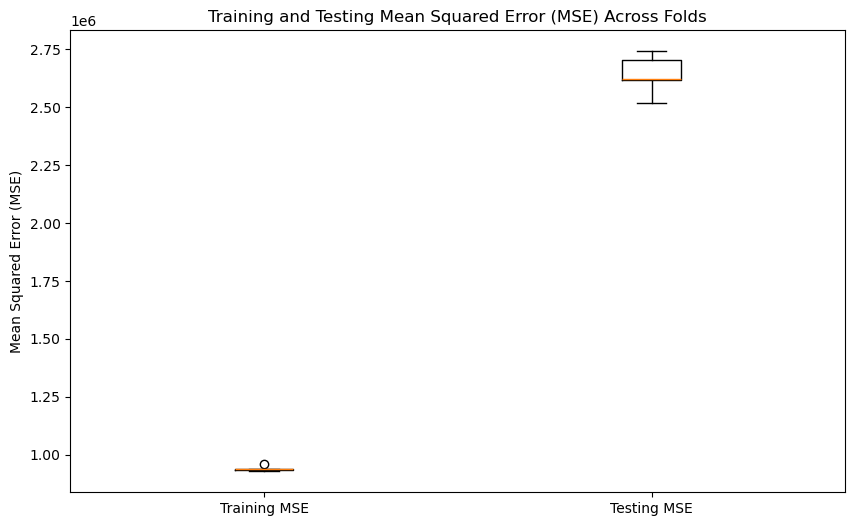

In [33]:
from sklearn.model_selection import cross_validate

# Define cross-validation strategy (e.g., 5-fold cross-validation)
cv_results = cross_validate(grid_search, X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# Extract train and test scores from cross-validation results
train_scores = -cv_results['train_score']  # Use negative scores for MSE
test_scores = -cv_results['test_score']

# Plot boxplot of training and testing MSE
plt.figure(figsize=(10, 6))
plt.boxplot([train_scores, test_scores], labels=['Training MSE', 'Testing MSE'])
plt.title('Training and Testing Mean Squared Error (MSE) Across Folds')
plt.ylabel('Mean Squared Error (MSE)')
plt.show()

### Part 2 - Optimisation

### 

In [ ]:
# Step 1: Read the file and extract relevant information
def read_file(file_path):
    # Implement file parsing logic to extract surgeon details, surgery details, and constraints
    pass

# Step 2: Implement the fitness function
def calculate_fitness(timetable):
    # Initialize constraint violation counters
    concurrence_violations = 0
    precedence_violations = 0
    
    # Iterate through each time slot in the timetable
    for time_slot in timetable:
        # Check concurrence constraints
        # Update concurrence_violations if needed
        
        # Check precedence constraints
        # Update precedence_violations if needed
    
    # Calculate fitness score
    fitness_score = concurrence_violations * precedence_violations
    return fitness_score

# Step 3: Test with a random timetable
def generate_random_timetable():
    # Implement logic to generate a random timetable
    pass

# Read the file and extract relevant information
surgeons, surgeries, constraints = read_file("file_path")

# Generate a random timetable
random_timetable = generate_random_timetable()

# Evaluate the fitness of the random timetable
fitness = calculate_fitness(random_timetable)
print("Fitness of Random Timetable:", fitness)